# Pitch Quality Analysis

## Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Preprocessing](#Preprocessing)
- [Fastball Analysis](#Fastball-Analysis)
    - [Top Fastball xQual](#Top-Fastballs-by-xQual)
    - [Fastball Break Plot xQual](#Fastball-Break-Plot-by-xQual)
- [Breaking Ball Analysis](#Breaking-Ball-Analysis)
    - [Top Breaking Ball xQual](#Top-Breaking-Balls-by-xQual)
    - [Breaking Ball HB & VB](#Breaking-Ball-Break-Plot-by-xQual)
- [Off-Speed Analysis](#Off-Speed-Analysis)
    - [Top Off-Speed xQual](#Top-Off-Speed-by-xQual)
    - [Off-Speed HB & VB](#Off-Speed-Break-Plot-by-xQual)

# Imports

In [1]:
from sklearn.preprocessing import scale, StandardScaler
from matplotlib.patches import Rectangle
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('../data/model-pitches-rv.csv', index_col = [0])
data.drop(columns = ['plate_x', 'release_pos_x'], inplace = True)
data.rename(columns = {'pfx_-x': 'pfx_x', 
                       'plate_-x': 'plate_x', 
                       'release_pos_-x': 'release_pos_x'}, 
            inplace = True)

rv_table = pd.read_csv('../data/rv_table.csv', index_col = [0])

xrv_grouped = pd.read_csv('../data/xrv_grouped.csv', index_col = [0])
pd.set_option('max_columns', None)
print(xrv_grouped.shape)
xrv_grouped.head()

(705434, 14)


,player_name,p_throws,pitch_type,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,rv,n_pitches,xRV,RV/100,xRV/100
0,"Gsellman, Robert",R,SI,94.3,16.20,10.56,1.20,6.05,6.5,-0.110,1,-0.070286,-11.0,-7.03
1,"Gsellman, Robert",R,SI,94.3,18.24,5.88,1.29,6.02,6.4,-0.047,1,-0.035488,-4.7,-3.55
2,"Gsellman, Robert",R,SI,94.2,17.04,6.36,1.41,5.88,6.4,-0.034,1,-0.054566,-3.4,-5.46
3,"Gsellman, Robert",R,SI,94.1,15.36,4.32,1.31,5.96,6.4,-0.135,1,-0.004550,-13.5,-0.45
4,"Gsellman, Robert",R,SI,93.6,15.48,6.96,1.42,5.89,6.5,-0.135,1,-0.108406,-13.5,-10.84


In [3]:
print(rv_table.shape)
rv_table.head()

(3469, 14)


,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,rv,xRV,RV/100,xRV/100
0,"Abbott, Cory",R,FF,207,92.6,9.6,17.2,2.6,5.5,6.2,5.7,1.4,2.7,0.7
1,"Abreu, Albert",R,FF,103,97.8,11.7,15.4,2.5,5.7,6.4,-1.5,-1.9,-1.5,-1.9
2,"Abreu, Albert",R,SI,212,98.0,15.3,13.3,2.5,5.6,6.5,1.0,0.3,0.4,0.2
3,"Abreu, Bryan",R,FF,310,95.7,8.0,17.1,1.5,6.0,6.3,-1.4,-1.5,-0.4,-0.5
4,"Abreu, Bryan",R,SI,2,96.0,14.2,14.9,1.9,5.9,6.4,-0.0,0.0,-1.2,1.6


# Preprocessing

### Slice Dataframes

In [4]:
rhp_fb = xrv_grouped[xrv_grouped['pitch_type'].isin(['FF', 'SI']) & (xrv_grouped['p_throws'] == 'R')]
lhp_fb = xrv_grouped[xrv_grouped['pitch_type'].isin(['FF', 'SI']) & (xrv_grouped['p_throws'] == 'L')]
fb = xrv_grouped[xrv_grouped['pitch_type'].isin(['FF', 'SI'])]
rhp_bb = xrv_grouped[xrv_grouped['pitch_type'].isin(['SL', 'FC', 'CU', 'KC']) & (xrv_grouped['p_throws'] == 'R')]
lhp_bb = xrv_grouped[xrv_grouped['pitch_type'].isin(['SL', 'FC', 'CU', 'KC']) & (xrv_grouped['p_throws'] == 'L')]
bb = xrv_grouped[xrv_grouped['pitch_type'].isin(['SL', 'FC', 'CU', 'KC'])]
rhp_os = xrv_grouped[xrv_grouped['pitch_type'].isin(['CH', 'FS']) & (xrv_grouped['p_throws'] == 'R')]
lhp_os = xrv_grouped[xrv_grouped['pitch_type'].isin(['CH', 'FS']) & (xrv_grouped['p_throws'] == 'L')]
os = xrv_grouped[xrv_grouped['pitch_type'].isin(['CH', 'FS'])]

fb_rvtable = rv_table[rv_table['pitch_type'].isin(['FF', 'SI'])]
bb_rvtable = rv_table[rv_table['pitch_type'].isin(['SL', 'FC', 'CU', 'KC'])]
os_rvtable = rv_table[rv_table['pitch_type'].isin(['CH', 'FS'])]

# Fastball Analysis

### Top Fastballs by xQual

In [5]:
cols = list(fb[['rv', 'xRV']])
fb[cols]

for col in cols:
    col_zscore = col + '_zscore'
    fb[col_zscore] = ((fb[col] - fb[col].mean()) / fb[col].std() * -1)

fb_stats = fb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                   as_index = False)['n_pitches', 'rv_zscore', 'xRV_zscore'].sum()

fb = pd.merge(fb, fb_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])   

fb['Qual'] = fb['rv_zscore_y'] + 100
fb['xQual'] = fb['xRV_zscore_y'] + 100

fb_qual = fb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                     as_index = False)['n_pitches_y', 'velo', 'pfx_x', 'pfx_z', 'release_pos_x', 
                                       'release_pos_z', 'release_extension', 
                                       'RV/100', 'Qual', 'xRV/100', 'xQual'].mean()

fb_qual.rename(columns = {'n_pitches_y': 'n_pitches'}, inplace = True)
fb_qual.n_pitches = fb_qual.n_pitches.astype(int)
fb_qual = fb_qual.round(1)
fb_r_rv = fb.loc[fb['p_throws'] == 'R']
fb_l_rv = fb.loc[fb['p_throws'] == 'L']
fb_qual.sort_values(by = 'xQual', ascending = False).head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,RV/100,Qual,xRV/100,xQual
951,"Ray, Robbie",L,FF,1864,94.8,-8.2,17.1,-2.5,6.1,6.5,-2.5,232.6,-2.2,347.6
229,"Cole, Gerrit",R,FF,1397,97.7,12.0,18.0,1.9,5.7,6.6,-2.5,199.5,-2.5,318.6
1249,"Wheeler, Zack",R,FF,1353,97.2,7.6,15.9,1.6,5.7,7.2,-2.7,206.2,-2.2,280.1
985,"Rodón, Carlos",L,FF,1302,95.4,-7.9,17.6,-2.0,6.7,6.1,-2.9,212.1,-2.1,262.1
725,"Matz, Steven",L,SI,1327,94.5,-15.0,12.3,-1.9,5.8,6.5,-1.5,141.2,-2.0,260.5
510,"Hendriks, Liam",R,FF,761,97.7,6.8,18.5,1.6,5.9,6.9,-3.4,180.4,-3.3,260.1
989,"Rogers, Trevor",L,FF,1249,94.5,-11.1,14.8,-2.2,5.9,6.6,-2.6,192.4,-2.1,256.3
726,"Matzek, Tyler",L,FF,753,96.0,-4.9,18.0,-1.8,6.3,6.3,-3.0,167.8,-3.2,253.7
698,"Mahle, Tyler",R,FF,1695,94.0,12.1,17.1,1.8,5.6,6.6,-2.1,194.7,-1.6,253.3
1309,"deGrom, Jacob",R,FF,704,99.2,9.1,16.4,1.1,5.5,6.9,-3.6,178.1,-3.4,251.6


### Fastball Break Plot by xQual

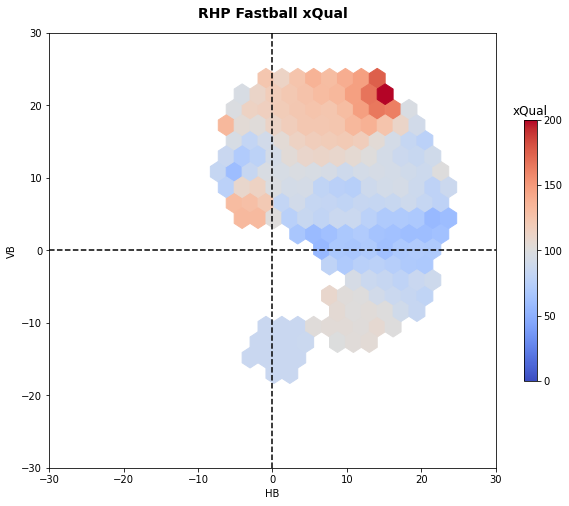

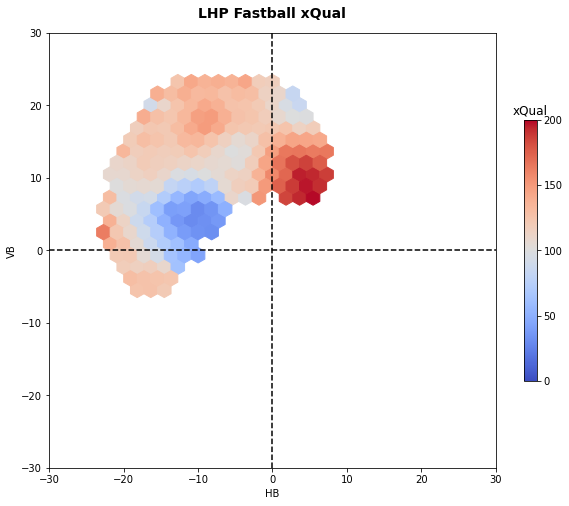

In [6]:
plt.figure(figsize = (10, 8))
plt.hexbin(fb_r_rv['pfx_x'], fb_r_rv['pfx_z'], C = fb_r_rv['xQual'], cmap = 'coolwarm', 
           mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball xQual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(fb_l_rv['pfx_x'], fb_l_rv['pfx_z'], C = fb_l_rv['xQual'], 
           cmap = 'coolwarm', mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Fastball xQual', fontsize = 14, fontweight = 'bold', pad = 15);

# Breaking Ball Analysis

### Top Breaking Balls by xQual

In [7]:
cols = list(bb[['rv', 'xRV']])
bb[cols]

for col in cols:
    col_zscore = col + '_zscore'
    bb[col_zscore] = ((bb[col] - bb[col].mean()) / bb[col].std() * -1)

bb_stats = bb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                   as_index = False)['n_pitches', 'rv_zscore', 'xRV_zscore'].sum()

bb = pd.merge(bb, bb_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])   

bb['Qual'] = bb['rv_zscore_y'] + 100
bb['xQual'] = bb['xRV_zscore_y'] + 100

bb_qual = bb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                     as_index = False)['n_pitches_y', 'velo', 'pfx_x', 'pfx_z', 'release_pos_x', 
                                       'release_pos_z', 'release_extension', 
                                       'RV/100', 'Qual', 'xRV/100', 'xQual'].mean()

bb_qual.rename(columns = {'n_pitches_y': 'n_pitches'}, inplace = True)
bb_qual.n_pitches = bb_qual.n_pitches.astype(int)
bb_qual = bb_qual.round(1)
bb_r_rv = bb.loc[bb['p_throws'] == 'R']
bb_l_rv = bb.loc[bb['p_throws'] == 'L']
bb_qual.sort_values(by = 'xQual', ascending = False).head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,RV/100,Qual,xRV/100,xQual
1327,"Urías, Julio",L,CU,952,81.4,15.8,-0.9,-1.6,6.1,5.5,-4.1,191.9,-4.2,290.4
898,"Morton, Charlie",R,CU,1095,80.6,-16.6,-10.1,2.1,5.5,6.2,-3.6,185.4,-3.4,262.9
817,"McCullers Jr., Lance",R,SL,719,86.0,-13.7,4.6,1.7,5.1,6.0,-3.7,157.7,-4.1,242.6
1097,"Rodón, Carlos",L,SL,603,85.8,8.2,-1.1,-2.3,6.5,6.0,-5.0,180.1,-4.5,235.9
823,"McHugh, Collin",R,SL,514,79.5,-18.7,-0.6,2.2,5.2,6.6,-4.8,164.0,-4.7,222.1
1331,"Valdez, Framber",L,CU,643,77.9,13.5,-15.3,-1.1,5.9,5.8,-4.1,162.8,-4.0,221.2
1446,"deGrom, Jacob",R,SL,409,91.6,-4.7,3.5,1.1,5.5,6.8,-5.5,162.5,-5.4,217.6
814,"McClanahan, Shane",L,SL,674,89.2,3.8,2.0,-0.8,6.2,6.8,-3.3,145.9,-3.7,214.1
607,"Jackson, Luke",R,SL,562,87.5,-1.4,-5.6,2.4,6.3,6.7,-4.3,158.8,-4.1,211.9
180,"Burnes, Corbin",R,CU,473,81.2,-11.3,-7.8,0.6,6.2,6.3,-4.8,160.0,-4.6,209.5


### Breaking Ball Break Plot by xQual

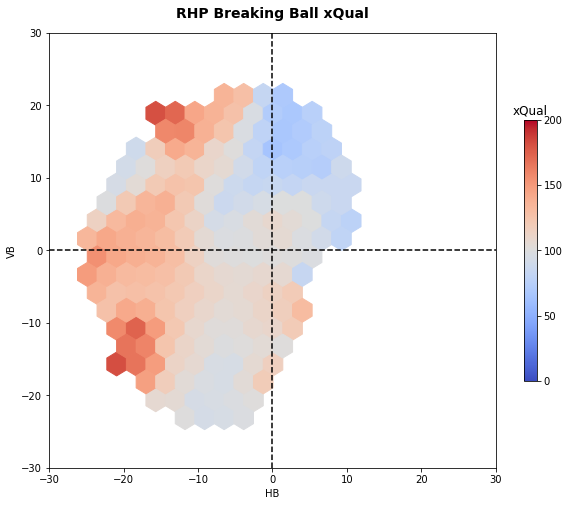

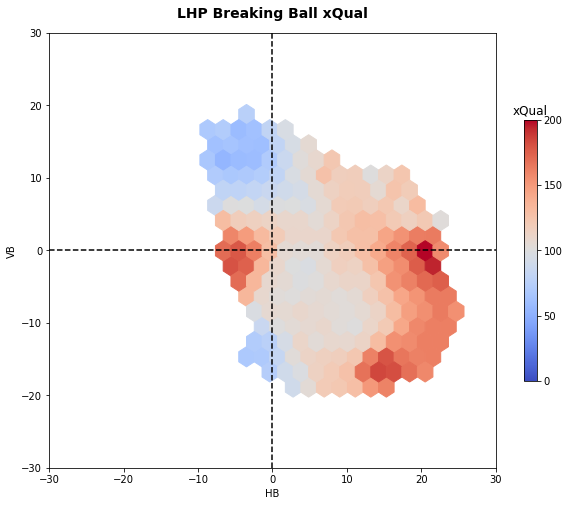

In [8]:
plt.figure(figsize = (10, 8))
plt.hexbin(bb_r_rv['pfx_x'], bb_r_rv['pfx_z'], C = bb_r_rv['xQual'], cmap = 'coolwarm', 
           mincnt = 15, gridsize = 20)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Breaking Ball xQual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(bb_l_rv['pfx_x'], bb_l_rv['pfx_z'], C = bb_l_rv['xQual'], cmap = 'coolwarm', 
           mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Breaking Ball xQual', fontsize = 14, fontweight = 'bold', pad = 15);

# Off-Speed Analysis

### Top Off-Speed by xQual

In [9]:
cols = list(os[['rv', 'xRV']])
os[cols]

for col in cols:
    col_zscore = col + '_zscore'
    os[col_zscore] = ((os[col] - os[col].mean()) / os[col].std() * -1)

os_stats = os.groupby(['player_name', 'p_throws', 'pitch_type'], 
                   as_index = False)['n_pitches', 'rv_zscore', 'xRV_zscore'].sum()

os = pd.merge(os, os_stats, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])   

os['Qual'] = os['rv_zscore_y'] + 100
os['xQual'] = os['xRV_zscore_y'] + 100

os_qual = os.groupby(['player_name', 'p_throws', 'pitch_type'], 
                     as_index = False)['n_pitches_y', 'velo', 'pfx_x', 'pfx_z', 'release_pos_x', 
                                       'release_pos_z', 'release_extension', 
                                       'RV/100', 'Qual', 'xRV/100', 'xQual'].mean()

os_qual.rename(columns = {'n_pitches_y': 'n_pitches'}, inplace = True)
os_qual.n_pitches = os_qual.n_pitches.astype(int)
os_qual = os_qual.round(1)
os_r_rv = os.loc[os['p_throws'] == 'R']
os_l_rv = os.loc[os['p_throws'] == 'L']
os_qual.sort_values(by = 'xQual', ascending = False).head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,RV/100,Qual,xRV/100,xQual
235,"Gausman, Kevin",R,FS,1044,83.6,12.3,2.2,2.7,5.9,6.5,-4.8,241.9,-4.2,330.2
432,"Montas, Frankie",R,FS,677,87.5,11.5,3.8,1.2,6.2,6.0,-4.1,173.8,-4.2,248.7
105,"Castillo, Luis",R,CH,952,88.3,16.8,0.9,2.8,5.0,5.6,-2.9,162.5,-3.0,233.1
392,"Manaea, Sean",L,CH,723,84.5,-12.2,6.7,-3.2,5.9,7.2,-3.0,147.7,-3.6,231.7
403,"Matz, Steven",L,CH,598,85.1,-15.9,3.3,-1.9,5.7,6.5,-3.3,147.9,-4.1,230.3
485,"Peralta, Wily",R,FS,352,81.3,10.2,6.7,1.1,6.6,5.8,-6.6,172.8,-6.3,228.6
466,"Ohtani, Shohei",R,FS,366,88.1,4.9,2.4,1.8,6.2,6.8,-6.4,172.6,-6.0,226.2
683,"Williams, Devin",R,CH,621,83.7,17.0,-4.2,2.3,5.4,6.8,-3.3,150.0,-3.6,213.4
204,"Flexen, Chris",R,CH,431,82.7,12.2,9.6,0.8,6.7,6.0,-3.8,143.0,-4.6,205.8
244,"Giolito, Lucas",R,CH,940,81.5,10.2,12.9,1.6,6.4,6.7,-2.3,139.8,-2.2,182.2


### Off-Speed Break Plot by xQual

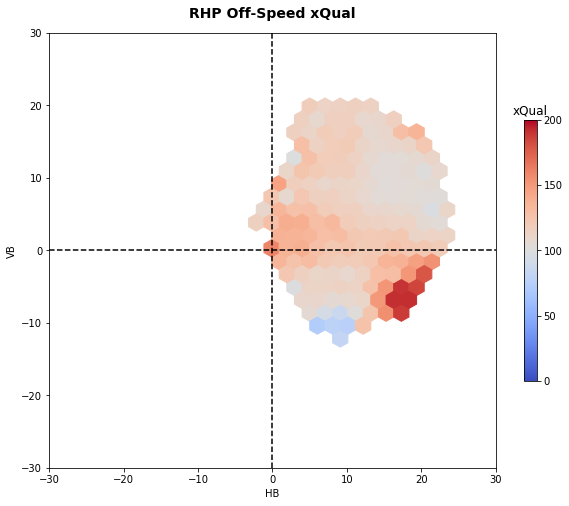

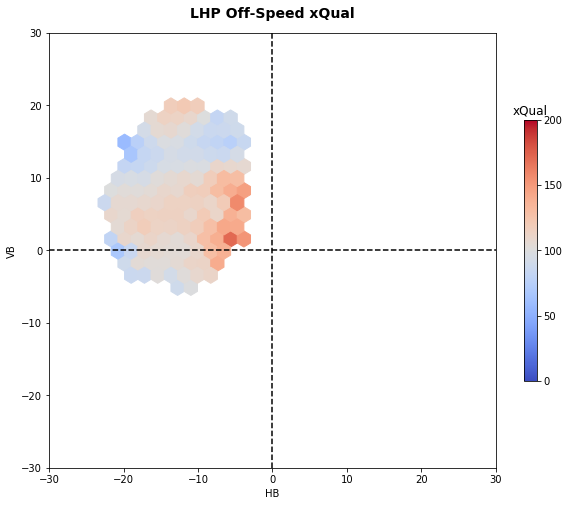

In [10]:
plt.figure(figsize = (10, 8))
plt.hexbin(os_r_rv['pfx_x'], os_r_rv['pfx_z'], C = os_r_rv['xQual'], cmap = 'coolwarm', 
           mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Off-Speed xQual', fontsize = 14, fontweight = 'bold', pad = 15)

plt.figure(figsize = (10, 8))
plt.hexbin(os_l_rv['pfx_x'], os_l_rv['pfx_z'], C = os_l_rv['xQual'], cmap = 'coolwarm', 
           mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .6)
cb.ax.set_title('xQual'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Off-Speed xQual', fontsize = 14, fontweight = 'bold', pad = 15);